### Notebook de prueba en Colab

Este es un notebook de prueba en Google Colab.

In [7]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
from io import BytesIO
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import time

In [32]:
BASE_URL = "https://www.vgamuseum.info/index.php/cards"

def fetch_html_vgamuseum(url):
    """Descarga y devuelve el HTML de una URL del sitio vgamuseum.info"""
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        return r.text
    except Exception as e:
        print(f"❌ Error al acceder a {url}: {e}")
        return None


def extract_category_links_vgamuseum(base_url):
    """Extrae todos los enlaces a categorías principales desde /cards"""
    html = fetch_html_vgamuseum(base_url)
    if not html:
        return []

    soup = BeautifulSoup(html, "html.parser")
    fulltext_div = soup.find("div", class_="itemFullText")
    if not fulltext_div:
        print("⚠️ No se encontró div.itemFullText en la página principal.")
        return []

    category_links = []
    for li in fulltext_div.find_all("li"):
        a_tag = li.find("a", href=True)
        if a_tag:
            full_url = urljoin(base_url, a_tag["href"])
            category_links.append(full_url)
    print(f"🔗 Encontradas {len(category_links)} categorías.")
    return category_links


def extract_subcategory_links_vgamuseum(category_url):
    """
    Extrae las subpáginas de tarjetas (por modelo o serie) dentro de una categoría,
    gestionando la paginación localizada en 'ul.pagination-list a.pagenav'.
    """
    html = fetch_html_vgamuseum(category_url)
    if not html:
        return []

    soup = BeautifulSoup(html, "html.parser")

    # 1️⃣ Obtener todas las URLs de paginación (incluyendo la página inicial)
    pagination_urls = [category_url]
    pagination_section = soup.select("ul.pagination-list a.pagenav")

    for a_tag in pagination_section:
        page_url = urljoin(category_url, a_tag["href"])
        if page_url not in pagination_urls:
            pagination_urls.append(page_url)

    print(f"  📁 {len(pagination_urls)} páginas de subcategorías encontradas en {category_url}")

    # 2️⃣ Iterar por todas las páginas (original + paginadas) y extraer subpáginas
    sub_links = []
    for page_url in pagination_urls:
        html_page = fetch_html_vgamuseum(page_url)
        if not html_page:
            continue

        soup_page = BeautifulSoup(html_page, "html.parser")

        for h3 in soup_page.find_all("h3", class_="catItemTitle"):
            a_tag = h3.find("a", href=True)
            if a_tag:
                full_url = urljoin(page_url, a_tag["href"])
                sub_links.append(full_url)

    print(f"  📁 {len(sub_links)} subcategorías encontradas en {category_url} (paginación incluida)")
    return sub_links


def extract_images_from_subpage_vgamuseum(sub_url):
    """
    Extrae todas las imágenes JPG dentro de div.itemFullText,
    descarta las que contengan 'driv' y devuelve también el título
    (h2.itemTitle dentro de div.itemHeader).
    """
    html = fetch_html_vgamuseum(sub_url)
    if not html:
        return []

    soup = BeautifulSoup(html, "html.parser")

    # 🔹 Obtener el título de la subpágina
    title = None
    header_div = soup.find("div", class_="itemHeader")
    if header_div:
        title_tag = header_div.find("h2", class_="itemTitle")
        if title_tag:
            title = title_tag.get_text(strip=True)

    fulltext_divs = soup.find_all("div", class_="itemFullText")
    images = []

    for div in fulltext_divs:
        for a_tag in div.find_all("a", href=True):
            href = a_tag["href"]
            if href.lower().endswith(".jpg"):
                img_url = urljoin(sub_url, href)

                # Descartar imágenes relacionadas con drivers
                if "driv" in img_url.lower() or "drv" in img_url.lower() or "driver" in img_url.lower():
                    print(f"    ⚠️ Descartada imagen de drivers: {img_url}")
                    continue

                images.append({
                    "title": title or "Sin título",
                    "image_url": img_url
                })

    if images:
        print(f"    🖼️ {len(images)} imágenes válidas encontradas en {sub_url} — {title or 'Sin título'}")
    return images


def scrape_vgamuseum_cards(base_url):
    """Scraper principal para recorrer todo el árbol de categorías y subcategorías con paginación"""
    all_data = []

    categories = extract_category_links_vgamuseum(base_url)

    print(f"\n🔎 Recuperadas {len(categories)} categorías principales.")

    included_categories = [
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/31-s3-graphics",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/2-3dfx",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/22-matrox",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/9-ati-technologies-inc",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/27-nvidia-corporation",
        "https://www.vgamuseum.info/index.php/cards/itemlist/category/39-trident-microsystems-inc"
    ]

    for cat_url in categories:
        if cat_url not in included_categories:
            continue

        sub_links = extract_subcategory_links_vgamuseum(cat_url)
        for sub_url in sub_links:
            images = extract_images_from_subpage_vgamuseum(sub_url)

            category_from_url = cat_url.split("/")[-1]
            category = "-".join(category_from_url.split("-")[1:])

            for img_info in images:
                all_data.append({
                    "category": category,
                    "category_url": cat_url,
                    "subpage_url": sub_url,
                    "title": img_info["title"],
                    "image_url": img_info["image_url"]
                })
            time.sleep(1)  # evita sobrecargar el servidor

    return all_data


# Ejecutar el scraping completo (sin guardar CSV)
cards = scrape_vgamuseum_cards(BASE_URL)

print(f"\n✅ Total de imágenes encontradas: {len(cards)}")
print("Ejemplo de resultados en memoria:")
for c in cards[:20]:
    print(f"- {c['category']} - {c['title']} - {c['image_url']}")


🔗 Encontradas 61 categorías.

🔎 Recuperadas 61 categorías principales.
  📁 1 páginas de subcategorías encontradas en https://www.vgamuseum.info/index.php/cards/itemlist/category/2-3dfx
  📁 11 subcategorías encontradas en https://www.vgamuseum.info/index.php/cards/itemlist/category/2-3dfx (paginación incluida)
    🖼️ 4 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/10-3dfx-voodoo-5-5500 — 3Dfx Voodoo 5 5500
    🖼️ 4 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/1046-3dfx-voodoo-4-4500 — 3Dfx Voodoo 4 4500
    🖼️ 3 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/8-3dfx-voodoo-3-3500 — 3Dfx Voodoo 3 3500
    🖼️ 17 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/7-3dfx-voodoo-3-3000 — 3Dfx Voodoo 3 3000
    🖼️ 14 imágenes válidas encontradas en https://www.vgamuseum.info/index.php/cards/item/6-3dfx-voodoo-3-2000 — 3Dfx Voodoo 3 2000
    🖼️ 2 imágenes válidas en

In [24]:
def download_images_as_binary(cards):
    """
    Dada una lista de diccionarios con 'title' y 'url',
    descarga cada imagen y devuelve una lista con (title, img_binary).
    """
    downloaded = []

    for card in cards:
        category = card.get("category")
        url = card.get("image_url")

        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            img_binary = BytesIO(response.content)
            downloaded.append((category, img_binary))
            print(f"Descargada: {category} ({url})")

        except Exception as e:
            print(f"⚠️ No se pudo descargar {url}: {e}")

    return downloaded


In [ ]:
binary_cards = download_images_as_binary(cards)
print(f"Total tarjetas descargadas: {len(binary_cards)}")

Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v5500fb.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v5500fzb.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/palcal/3dfx/788_3dfx_voodoo_5_5500_top_hq.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/palcal/3dfx/788_3dfx_voodoo_5_5500_bottom_hq.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/pepino/3dfx/3dfx_voodoo4_4500_f.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/pepino/3dfx/3dfx_voodoo4_4500_b.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/demiurge/minime/img520.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/demiurge/minime/img521.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33500f.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33500fz.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33500cable.jpg)
Descargada: 3dfx (https://www.vgamuseum.info/images/vlask/3dfx/v33000fb.jpg

In [33]:
def get_image_size_stats(binary_images):
    """
    Calcula el tamaño mínimo y máximo (ancho y alto) de una lista de imágenes.
    binary_images: lista de tuplas (title, img_binary)
    """
    widths, heights = [], []

    for category, img_binary in binary_images:
        try:
            with Image.open(img_binary) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"⚠️ No se pudo abrir imagen '{category}': {e}")

    if not widths or not heights:
        print("❌ No se pudo calcular tamaños.")
        return None

    stats = {
        "min_width": min(widths),
        "max_width": max(widths),
        "min_height": min(heights),
        "max_height": max(heights),
        "count": len(widths)
    }

    print(f"📊 Total imágenes analizadas: {stats['count']}")
    print(f"📏 Ancho -> min: {stats['min_width']}, max: {stats['max_width']}")
    print(f"📐 Alto  -> min: {stats['min_height']}, max: {stats['max_height']}")

    return stats


In [27]:
stats = get_image_size_stats(binary_cards)

📊 Total imágenes analizadas: 1112
📏 Ancho -> min: 241, max: 6917
📐 Alto  -> min: 215, max: 4135


In [28]:
def prepare_images_for_mobilenet_tf(binary_images, batch_size=32):
    """
    Prepara imágenes y etiquetas para MobileNetV2 usando TensorFlow/Keras.

    binary_images: lista de tuplas (title, img_binary)
    batch_size: tamaño de batch para el generador

    Devuelve:
        train_generator (ImageDataGenerator)
        label_encoder (LabelEncoder) para decodificar las etiquetas si se necesita
    """
    X, y = [], []

    # Procesar imágenes
    for category, img_binary in binary_images:
        try:
            img_binary.seek(0)
            img = Image.open(img_binary).convert("RGB")
            img_array = np.array(img)
            img_resized = tf.image.resize(img_array, [224, 224])
            X.append(img_resized.numpy())
            y.append(category)
        except Exception as e:
            print(f"⚠️ No se pudo procesar la imagen '{category}': {e}")

    X = np.array(X)
    y = np.array(y)

    # Codificar etiquetas
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)        # entero por clase
    y_onehot = to_categorical(y_encoded)              # one-hot encoding

    # Generador de datos con aumento y normalización
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = datagen.flow(X, y_onehot, batch_size=batch_size)
    print(f"✅ Generador preparado con {len(X)} imágenes y {len(label_encoder.classes_)} clases.")
    return train_generator, label_encoder

In [29]:
train_gen, le = prepare_images_for_mobilenet_tf(binary_cards, batch_size=32)

# Comprobar un batch
X_batch, y_batch = next(train_gen)
print(X_batch.shape, y_batch.shape)

✅ Generador preparado con 1112 imágenes y 3 clases.
(32, 224, 224, 3) (32, 3)


In [30]:
for i, y_vec in enumerate(y_batch):
    class_index = np.argmax(y_vec)           # obtener el índice de la clase
    class_name = le.classes_[class_index]   # decodificar a nombre original
    print(f"Imagen {i} -> Class Name: '{class_name}' / Vector: '{y_vec}'")

Imagen 0 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 1 -> Class Name: '3dfx' / Vector: '[1. 0. 0.]'
Imagen 2 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 3 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 4 -> Class Name: 'trident-microsystems-inc' / Vector: '[0. 0. 1.]'
Imagen 5 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 6 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 7 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 8 -> Class Name: 'trident-microsystems-inc' / Vector: '[0. 0. 1.]'
Imagen 9 -> Class Name: '3dfx' / Vector: '[1. 0. 0.]'
Imagen 10 -> Class Name: 'trident-microsystems-inc' / Vector: '[0. 0. 1.]'
Imagen 11 -> Class Name: '3dfx' / Vector: '[1. 0. 0.]'
Imagen 12 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 13 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 14 -> Class Name: '3dfx' / Vector: '[1. 0. 0.]'
Imagen 15 -> Class Name: 's3-graphics' / Vector: '[0. 1. 0.]'
Imagen 

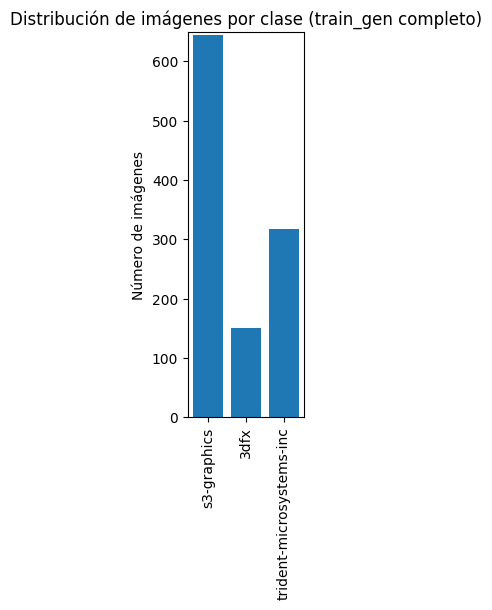

In [31]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

decoded_labels = []

# Iterar sobre todos los batches del generador
for i in range(len(train_gen)):
    X_batch, y_batch = train_gen[i]  # obtener batch i
    decoded_labels.extend([le.classes_[np.argmax(y_vec)] for y_vec in y_batch])

# Contar ocurrencias por clase
from collections import Counter
counter = Counter(decoded_labels)
labels = list(counter.keys())
counts = list(counter.values())

# Dibujar gráfico
import matplotlib.pyplot as plt
plt.figure(figsize=(len(labels)*0.5, 5))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.ylim(0, max(counts)+5)
plt.ylabel("Número de imágenes")
plt.title("Distribución de imágenes por clase (train_gen completo)")
plt.show()